# Next frame prediction

The project consists of predicting the next frame in a short movie sequence.

For this project, we shall use the Moving MNIST dataset, composed of 10,000 video sequences, each consisting of 20 frames. In each video sequence, two digits move independently around the frame, which has a spatial resolution of 64×64 pixels. The digits frequently intersect with each other and bounce off the edges of the frame.

While each sequence has a lenght of 20, we are supposed to use **only 3 consecutive frames as input**, and **predict the next one**.

The metric used to evalaute the quality of the predicted frame is Mean Squared Error.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras.layers import Input, ConvLSTM2D, BatchNormalization, Conv3D, Conv2D, Conv3DTranspose, Attention, Concatenate, MaxPooling3D
from keras.regularizers import l2

import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'tensorflow'

Utility functions

In [2]:
def image_generator(dataset,batchsize=16,seqlen=4):
    while True:
      batch_x = np.zeros((batchsize,seqlen-1,64,64,1))
      batch_y = np.zeros((batchsize,1,64,64,1))
      ran = np.random.randint(dataset.shape[0],size=batchsize)
      # add channel dimension
      minibatch = np.expand_dims(dataset[ran], axis=-1)
      #these sequences have length 20; we reduce them to seqlen
      for i in range(batchsize):
          random_start = np.random.randint(0,20-seqlen)
          random_end = random_start+seqlen-1
          batch_x[i] = minibatch[i,random_start:random_end,:,:,:]
          batch_y[i] = minibatch[i,random_end:random_end+1,:,:,:]
          #print(batch_x.shape,batch_y.shape)
          #print(batch_x.min(),batch_x.max())
          #print(batch_x.min(),batch_x.max())
      yield(batch_x,batch_y)

In [3]:
def show_list(images, title="Target"): #takes in input a list of images and plot them
    size = len(images)
    plt.figure(figsize=(10, 10 * size))
    for i in range(size):
        plt.subplot(1, size, i + 1)
        plt.imshow(images[i],cmap='gray',)
        if i == size-1:
            plt.title(f"{title}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
def compute_mse(model, test_gen, test_step=100):
  mse = tf.keras.losses.MeanSquaredError()
  
  avg_mse = 0

  for i in range(test_step):
    sample_x, sample_y = next(test_gen)
    y_pred = model.predict(sample_x, verbose=0)
    
    avg_mse += mse(np.squeeze(sample_y), np.squeeze(y_pred)[2]).numpy()

  return avg_mse/test_step

In [5]:
def visual_test(model, model_name, sample_x, sample_y):

    sample_y = np.squeeze(sample_y)
    
    original_frames = [np.squeeze(sample_x[:,i,:,:,:]) for i in range(3)]
    new_prediction = model.predict(sample_x, verbose=0)

    show_list(original_frames + [np.squeeze(new_prediction)[-1]], model_name)
    # model.evaluate(test_gen, steps=100)

In [6]:
def compare_models_visual(models, test_gen):
    sample_x, sample_y = next(test_gen)

    original_frames = [np.squeeze(sample_x[:,i,:,:,:]) for i in range(3)]

    show_list(original_frames + [np.squeeze(sample_y)])

    for model in models.values():
        visual_test(model["model"], model["name"], sample_x, sample_y)

In [7]:
def compare_models_mse(models, test_gen):
    for model in models.values():
        print(f'Evaluating {model["name"]}')
        model["model"].evaluate(test_gen, steps=1000, verbose=1)
        # print(f'Loss: {res[0]} - MSE: {res[1]}')
        # mse = compute_mse(model["model"], test_gen)

In [8]:
def train_model(model, train_gen, val_gen, epochs=20, steps_per_epoch=100, val_steps=10, callbacks=[]):
    history = model.fit(
        train_gen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=val_steps,
        validation_data=val_gen,
        callbacks=callbacks,
    )
    return history

In [9]:
def get_weights_range(model):
    min_value = np.inf
    max_value = -np.inf

    for layer_weights in model.get_weights():
        layer_min = np.min(layer_weights)
        layer_max = np.max(layer_weights)
        
        if layer_min < min_value:
            min_value = layer_min
        if layer_max > max_value:
            max_value = layer_max

    print(f"Weight range: {min_value} - {max_value}")

In [10]:
def plot_weight_distribution(model):
    # Get the weights of the model
    weights = model.get_weights()
    
    # Concatenate all weights into a single 1D array
    flattened_weights = np.concatenate([w.flatten() for w in weights])
    
    # Plot the weight value distribution
    plt.hist(flattened_weights, bins=100)
    plt.xlabel('Weight Values')
    plt.ylabel('Frequency')
    plt.title('Weight Value Distribution')
    plt.show()

In [11]:
def buildInceptionModule(input_layer):
    tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
    tower_1 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
    tower_2 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_2)    
    
    tower_3 = MaxPooling3D((3,3,3), strides=(1,1,1), padding='same')(input_layer)
    tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)
    
    tower_4 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)

    output = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4])

    return output

Custom Callback

In [12]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super().__init__()
        self.schedule = schedule
        self.current_lr = None

    def lr_schedule(self, epoch, lr):
        """Helper function to retrieve the scheduled learning rate based on epoch."""
        if epoch < self.schedule[0][0] or epoch > self.schedule[-1][0]:
            return lr
        for i in range(len(self.schedule)):
            if epoch == self.schedule[i][0]:
                return self.schedule[i][1]
        return lr

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        self.current_lr = self.lr_schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, self.current_lr)
        # print(" LR %6.4f." % (self.current_lr))
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs["lr"] = self.current_lr

Data loading

In [9]:
# Use this one to load directly from tensorflow_dataset

# ds = tfds.as_numpy(tfds.load(
#     'moving_mnist',
#     split='test',
#     batch_size=-1
# ))
# sequences = ds['image_sequence']

In [13]:
# Use this to load from file, this approach weigh less on RAM
sequences=np.load('./mnist_test_seq.npy')
sequences.shape

(20, 10000, 64, 64)

The dataset is composed of 10000 sequences of 20 frames each. Each (grayscale) frame has dimnesion 64x64

In [14]:
# sequences = np.squeeze(np.swapaxes(sequences, 1, 4),axis=1)/255.
sequences = np.swapaxes(sequences, 0, 1)/255.
print(sequences.shape)
print(np.min(sequences),np.max(sequences))

(10000, 20, 64, 64)
0.0 1.0


In [15]:
train_samples = 8000

In [16]:
trainset = sequences[:train_samples]
valset = sequences[train_samples:train_samples+1000]
testset = sequences[train_samples:train_samples+1000]

In [16]:
testset.shape

(1000, 20, 64, 64)

In [17]:
train_gen = image_generator(trainset, batchsize=16)
val_gen = image_generator(valset, batchsize=16)
test_gen = image_generator(valset, batchsize=1)

In [18]:
sample_x, sample_y = next(train_gen)

In [19]:
sample_x.shape

(16, 3, 64, 64, 1)

We start analyzing the problem by tacking as baseline the 3 layer convolutional LSTM model proposed in the keras documentation (https://keras.io/examples/vision/conv_lstm/).

The training is set up with 300 steps per epoch and 20 epochs to have approximately 20 minutes training per model on my machine, in this way we can try different models with different setup and hyperparameters without waiting too much. 
After this first phase we can train the most promising model more extensively with 500 steps per epoch and 30 epochs.

In the initial setup (300/20) the 3-layer LSTM model had an avg. MSE of 0.016, this initial value was taken as a baseline for the different models tried later.
The architectures that follows are mostly based on the literature on the moving MNIST dataset, although in the papers usually the input is a sequence of 10 frames.

Simply using larger kernels (7x7) did not improve the score, although there are some competitive models (SimVP) that are able to achieve state-of-the-art results with even bigger kernels (9x9). Moreover batch normalization and weight decay seems to be beneficial to almost all the models.
All the models were trained with a learning rate of 0.005 for the first 10 epoch and 0.001 for the remaining 10, this schedule was derived empirically, of course more grounded tests like learning range test would give more reliable values. 

Following there is a list of the trained architectures:

- Encoder-Decoder
- Encoder-Decoder with attentioned input
- Encoder-Decoder with attentioned input and attention layer before decoder
- Encoder-Decoder with attentioned input and residual connection
- Encoder-Decoder with vanilla inception module before decoder 

## Models Definitions

In [ ]:
# One layer Conv
inp = Input(shape=(3, 64, 64, 1))

conv1 = Conv2D(
    filters=64,
    kernel_size=(5, 5),
    padding='same',
    # return_sequences=True,
    kernel_regularizer=l2(0.01),
    activation="relu",)(inp)
norm1 = BatchNormalization()(conv1)

out = Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(norm1)

model_1_conv = keras.models.Model(inp, out)
model_1_conv.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.005), metrics=['mse'])

model_1_conv.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 64, 64, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 3, 64, 64, 64)     1664      
                                                                 
 batch_normalization_3 (Batc  (None, 3, 64, 64, 64)    256       
 hNormalization)                                                 
                                                                 
 conv3d_1 (Conv3D)           (None, 3, 64, 64, 1)      1729      
                                                                 
Total params: 3,649
Trainable params: 3,521
Non-trainable params: 128
_________________________________________________________________


In [ ]:
# One layer LSTM Convolution
inp = Input(shape=(None, 64, 64, 1))

conv1 = ConvLSTM2D(
    filters=64,
    kernel_size=(7, 7),
    padding='same',
    return_sequences=True,
    kernel_regularizer=l2(0.001),
    activation="relu",)(inp)

norm1 = BatchNormalization()(conv1)

out = Conv2D(
    filters=1, kernel_size=(7, 7), activation="sigmoid", padding="same")(norm1)

model_1lstm_conv = keras.models.Model(inp, out)
model_1lstm_conv.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.005), metrics=['mse'])

model_1lstm_conv.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 64, 64, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, None, 64, 64, 64)  815616    
                                                                 
 batch_normalization_4 (Batc  (None, None, 64, 64, 64)  256      
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, None, 64, 64, 1)   3137      
                                                                 
Total params: 819,009
Trainable params: 818,881
Non-trainable params: 128
_________________________________________________________________


In [31]:
# 3 layer LSTM Convolution
inp = Input(shape=(None, 64, 64, 1))

conv1 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
norm1 = BatchNormalization()(conv1)

conv2 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(norm1)
norm2 = BatchNormalization()(conv2)

conv3 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(norm2)

out = Conv3D(
    filters=1, 
    kernel_size=(3, 3, 3),
    kernel_regularizer=l2(0.01),
    padding="same", 
    activation="sigmoid", 
)(conv3)

model_3lstm_conv = keras.models.Model(inp, out)
model_3lstm_conv.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.005, weight_decay=0.0001), metrics=['mse'])

model_3lstm_conv.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, 64, 64, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d_19 (ConvLSTM2D)  (None, None, 64, 64, 64)  416256   
                                                                 
 batch_normalization_16 (Bat  (None, None, 64, 64, 64)  256      
 chNormalization)                                                
                                                                 
 conv_lstm2d_20 (ConvLSTM2D)  (None, None, 64, 64, 64)  819456   
                                                                 
 batch_normalization_17 (Bat  (None, None, 64, 64, 64)  256      
 chNormalization)                                                
                                                           

In [22]:
# Autoencoder Convolutional LSTM
inp = Input(shape=(None, 64, 64, 1))

enc1 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=True,
    activation="relu",)(inp)
norm1 = BatchNormalization()(enc1)

enc2 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(2,2),
    padding='same',
    return_sequences=True,
    activation="relu",)(norm1)
norm2 = BatchNormalization()(enc2)

dec1 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=True,
    activation="relu",)(norm2)

dec2 = Conv3DTranspose(
    filters=64,
    kernel_size=(3, 5, 5),
    strides=(1, 2, 2),
    padding='same'
)(dec1)

out = Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(dec2)


model_autoenc = keras.models.Model(inp, out)
model_autoenc.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.005, weight_decay=0.0001), metrics=['mse'])

model_autoenc.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, 64, 64, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d_13 (ConvLSTM2D)  (None, None, 64, 64, 64)  416256   
                                                                 
 batch_normalization_12 (Bat  (None, None, 64, 64, 64)  256      
 chNormalization)                                                
                                                                 
 conv_lstm2d_14 (ConvLSTM2D)  (None, None, 32, 32, 64)  819456   
                                                                 
 batch_normalization_13 (Bat  (None, None, 32, 32, 64)  256      
 chNormalization)                                                
                                                           

In [21]:
# Autoencoder Attention Convolutional LSTM
inp = Input(shape=(None, 64, 64, 1))

att1 = Attention()([inp, inp])

enc1 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=True,
    activation="relu",)(att1)
norm1 = BatchNormalization()(enc1)

enc2 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(2,2),
    padding='same',
    return_sequences=True,
    activation="relu",)(norm1)
norm2 = BatchNormalization()(enc2)


dec1 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=True,
    activation="relu",)(norm2)
norm3 = BatchNormalization()(dec1)

dec2 = Conv3DTranspose(
    filters=64,
    kernel_size=(3, 5, 5),
    strides=(1, 2, 2),
    padding='same'
)(norm3)

out = Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(dec2)


model_autoenc_att = keras.models.Model(inp, out)
# model_autoenc_att.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.005), metrics=['mse'])
model_autoenc_att.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.005, weight_decay=0.0001), metrics=['mse'])

model_autoenc_att.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, 64, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 attention_3 (Attention)        (None, None, 64, 64  0           ['input_4[0][0]',                
                                , 1)                              'input_4[0][0]']                
                                                                                                  
 conv_lstm2d_10 (ConvLSTM2D)    (None, None, 64, 64  416256      ['attention_3[0][0]']            
                                , 64)                                                       

In [20]:
# Attention-Encoder-Attention-Decoder Convolutional LSTM
inp = Input(shape=(None, 64, 64, 1))

att1 = Attention()([inp, inp])

enc1 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=True,
    activation="relu",)(att1)
norm1 = BatchNormalization()(enc1)

enc2 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(2,2),
    padding='same',
    return_sequences=True,
    activation="relu",)(norm1)
norm2 = BatchNormalization()(enc2)

att2 = Attention()([norm2, norm2])

dec1 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=True,
    activation="relu",)(att2)
norm3 = BatchNormalization()(dec1)

dec2 = Conv3DTranspose(
    filters=64,
    kernel_size=(3, 5, 5),
    strides=(1, 2, 2),
    padding='same'
)(norm3)

out = Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(dec2)


model_autoenc_att2 = keras.models.Model(inp, out)
# model_autoenc_att.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.005), metrics=['mse'])
model_autoenc_att2.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.005, weight_decay=0.0001), metrics=['mse'])

model_autoenc_att2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 64, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 attention_1 (Attention)        (None, None, 64, 64  0           ['input_3[0][0]',                
                                , 1)                              'input_3[0][0]']                
                                                                                                  
 conv_lstm2d_7 (ConvLSTM2D)     (None, None, 64, 64  416256      ['attention_1[0][0]']            
                                , 64)                                                       

In [19]:
# Autoencoder+Attention+Residual Convolutional LSTM
inp = Input(shape=(None, 64, 64, 1))

att1 = Attention()([inp, inp])

enc1 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=True,
    activation="relu",)(att1)
norm1 = BatchNormalization()(enc1)

enc2 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(2,2),
    padding='same',
    return_sequences=True,
    activation="relu",)(norm1)
norm2 = BatchNormalization()(enc2)

dec1 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=True,
    activation="relu",)(norm2)
norm3 = BatchNormalization()(dec1)

dec2 = Conv3DTranspose(
    filters=64,
    kernel_size=(3, 5, 5),
    strides=(1, 2, 2),
    padding='same'
)(norm3)

concat1 = Concatenate()([norm1, dec2])

dec3 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=True,
    activation="relu",)(concat1)


out = Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(dec3)


model_autoenc_att_res = keras.models.Model(inp, out)
model_autoenc_att_res.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001), metrics=['mse'])

model_autoenc_att_res.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 64, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 attention (Attention)          (None, None, 64, 64  0           ['input_2[0][0]',                
                                , 1)                              'input_2[0][0]']                
                                                                                                  
 conv_lstm2d_3 (ConvLSTM2D)     (None, None, 64, 64  416256      ['attention[0][0]']              
                                , 64)                                                       

In [18]:
# Encoder-Inception-Decoder Convolutional LSTM
inp = Input(shape=(None, 64, 64, 1))

# att1 = Attention()([inp, inp])

enc1 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=True,
    activation="relu",)(inp)
norm1 = BatchNormalization()(enc1)

enc2 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(2,2),
    padding='same',
    return_sequences=True,
    activation="relu",)(norm1)
norm2 = BatchNormalization()(enc2)

inc1 = buildInceptionModule(norm2)

dec1 = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=True,
    activation="relu",)(inc1)
norm3 = BatchNormalization()(dec1)

dec2 = Conv3DTranspose(
    filters=64,
    kernel_size=(3, 5, 5),
    strides=(1, 2, 2),
    padding='same'
)(norm3)


out = Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(dec2)


model_autoenc_inc = keras.models.Model(inp, out)
model_autoenc_inc.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.005, weight_decay=0.0001), metrics=['mse'])

model_autoenc_inc.summary()

2023-07-09 12:30:59.949566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-09 12:31:02.246083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-09 12:31:02.246403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 64, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, None, 64, 64  416256      ['input_1[0][0]']                
                                , 64)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, None, 64, 64  256        ['conv_lstm2d[0][0]']            
 alization)                     , 64)                                                         

## Training 300 steps / 20 epochs

In [32]:
LR_SCHEDULE = [
    (10, 0.001),
]

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_mse", patience=3, min_lr=0.001, factor=0.2)
reduce_lr = CustomLearningRateScheduler(LR_SCHEDULE)

In [33]:
train_model(model_3lstm_conv, train_gen, val_gen, steps_per_epoch=300, val_steps=60, callbacks=[early_stopping, reduce_lr])

Epoch 1/20


2023-07-09 17:11:30.184361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - ETA: 0s - loss: 0.1252 - mse: 0.0272

2023-07-09 17:13:17.128015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - 114s 366ms/step - loss: 0.1252 - mse: 0.0272 - val_loss: 0.1734 - val_mse: 0.0357 - lr: 0.0050
Epoch 2/20
300/300 [==============================] - 111s 371ms/step - loss: 0.0866 - mse: 0.0204 - val_loss: 0.1001 - val_mse: 0.0237 - lr: 0.0050
Epoch 3/20
300/300 [==============================] - 112s 373ms/step - loss: 0.0829 - mse: 0.0193 - val_loss: 0.0827 - val_mse: 0.0192 - lr: 0.0050
Epoch 4/20
300/300 [==============================] - 112s 375ms/step - loss: 0.0810 - mse: 0.0187 - val_loss: 0.0792 - val_mse: 0.0181 - lr: 0.0050
Epoch 5/20
300/300 [==============================] - 113s 376ms/step - loss: 0.0792 - mse: 0.0181 - val_loss: 0.0790 - val_mse: 0.0180 - lr: 0.0050
Epoch 6/20
300/300 [==============================] - 113s 376ms/step - loss: 0.0786 - mse: 0.0179 - val_loss: 0.0771 - val_mse: 0.0174 - lr: 0.0050
Epoch 7/20
300/300 [==============================] - 113s 378ms/step - loss: 0.0785 - mse: 0.0178 - val_loss: 0.0779

In [49]:
train_model(model_autoenc_att, train_gen, val_gen, steps_per_epoch=300, val_steps=60, callbacks=[early_stopping, reduce_lr])

Epoch 1/20


2023-07-08 11:35:10.645413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - ETA: 0s - loss: 0.1733 - mse: 0.0382

2023-07-08 11:36:21.688174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - 76s 222ms/step - loss: 0.1733 - mse: 0.0382 - val_loss: 0.2551 - val_mse: 0.0411 - lr: 0.0050
Epoch 2/20
300/300 [==============================] - 66s 220ms/step - loss: 0.1220 - mse: 0.0297 - val_loss: 0.1557 - val_mse: 0.0349 - lr: 0.0050
Epoch 3/20
300/300 [==============================] - 66s 221ms/step - loss: 0.1084 - mse: 0.0266 - val_loss: 0.1067 - val_mse: 0.0261 - lr: 0.0050
Epoch 4/20
300/300 [==============================] - 67s 222ms/step - loss: 0.1045 - mse: 0.0256 - val_loss: 0.1044 - val_mse: 0.0252 - lr: 0.0050
Epoch 5/20
300/300 [==============================] - 68s 227ms/step - loss: 0.1012 - mse: 0.0246 - val_loss: 0.1009 - val_mse: 0.0244 - lr: 0.0050
Epoch 6/20
300/300 [==============================] - 67s 224ms/step - loss: 0.0994 - mse: 0.0241 - val_loss: 0.1004 - val_mse: 0.0244 - lr: 0.0050
Epoch 7/20
300/300 [==============================] - 67s 222ms/step - loss: 0.0982 - mse: 0.0237 - val_loss: 0.0963 - val_

In [25]:
train_model(model_autoenc_att2, train_gen, val_gen, steps_per_epoch=300, val_steps=60, callbacks=[early_stopping, reduce_lr])

Epoch 1/20


2023-07-08 12:19:32.086166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-08 12:19:37.466595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-08 12:19:41.765127: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f95cfc76220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-08 12:19:41.765153: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2023-07-08 12:19:41.876937: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-08 1

300/300 [==============================] - ETA: 0s - loss: 0.1816 - mse: 0.0376

2023-07-08 12:20:44.229592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - 77s 216ms/step - loss: 0.1816 - mse: 0.0376 - val_loss: 0.1581 - val_mse: 0.0351 - lr: 0.0050
Epoch 2/20
300/300 [==============================] - 65s 216ms/step - loss: 0.1302 - mse: 0.0312 - val_loss: 0.1606 - val_mse: 0.0366 - lr: 0.0050
Epoch 3/20
300/300 [==============================] - 65s 218ms/step - loss: 0.1195 - mse: 0.0290 - val_loss: 0.5423 - val_mse: 0.1888 - lr: 0.0050
Epoch 4/20
300/300 [==============================] - 66s 219ms/step - loss: 0.1161 - mse: 0.0282 - val_loss: 0.1300 - val_mse: 0.0319 - lr: 0.0050
Epoch 5/20
300/300 [==============================] - 66s 220ms/step - loss: 0.1167 - mse: 0.0283 - val_loss: 0.4243 - val_mse: 0.0403 - lr: 0.0050
Epoch 6/20
300/300 [==============================] - 66s 219ms/step - loss: 0.1123 - mse: 0.0274 - val_loss: 0.1218 - val_mse: 0.0280 - lr: 0.0050
Epoch 7/20
300/300 [==============================] - 66s 221ms/step - loss: 0.1090 - mse: 0.0267 - val_loss: 0.1165 - val_

In [101]:
train_model(model_autoenc, train_gen, val_gen, steps_per_epoch=300, val_steps=60, callbacks=[early_stopping, reduce_lr])

Epoch 1/20


2023-07-07 18:39:09.618152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - ETA: 0s - loss: 0.1029 - mse: 0.0238

2023-07-07 18:40:16.715124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - 72s 217ms/step - loss: 0.1029 - mse: 0.0238 - val_loss: 0.4090 - val_mse: 0.1120 - lr: 0.0050
Epoch 2/20
300/300 [==============================] - 65s 218ms/step - loss: 0.0731 - mse: 0.0167 - val_loss: 0.0782 - val_mse: 0.0181 - lr: 0.0050
Epoch 3/20
300/300 [==============================] - 66s 220ms/step - loss: 0.0696 - mse: 0.0155 - val_loss: 0.0695 - val_mse: 0.0152 - lr: 0.0050
Epoch 4/20
300/300 [==============================] - 66s 220ms/step - loss: 0.0670 - mse: 0.0146 - val_loss: 0.0646 - val_mse: 0.0138 - lr: 0.0050
Epoch 5/20
300/300 [==============================] - 66s 221ms/step - loss: 0.0657 - mse: 0.0141 - val_loss: 0.0710 - val_mse: 0.0154 - lr: 0.0050
Epoch 6/20
300/300 [==============================] - 66s 221ms/step - loss: 0.0649 - mse: 0.0138 - val_loss: 0.0647 - val_mse: 0.0138 - lr: 0.0050
Epoch 7/20
300/300 [==============================] - 66s 221ms/step - loss: 0.0632 - mse: 0.0133 - val_loss: 0.0632 - val_

In [38]:
train_model(model_autoenc_att_res, train_gen, val_gen, steps_per_epoch=300, val_steps=60, callbacks=[early_stopping])

Epoch 1/20


2023-07-08 15:06:15.251301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - ETA: 0s - loss: 0.0985 - mse: 0.0239

2023-07-08 15:08:16.151193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - 130s 409ms/step - loss: 0.0985 - mse: 0.0239 - val_loss: 0.6400 - val_mse: 0.0420
Epoch 2/20
300/300 [==============================] - 124s 413ms/step - loss: 0.0721 - mse: 0.0163 - val_loss: 0.1159 - val_mse: 0.0290
Epoch 3/20
300/300 [==============================] - 124s 415ms/step - loss: 0.0676 - mse: 0.0146 - val_loss: 0.0671 - val_mse: 0.0144
Epoch 4/20
300/300 [==============================] - 125s 417ms/step - loss: 0.0647 - mse: 0.0137 - val_loss: 0.0646 - val_mse: 0.0137
Epoch 5/20
300/300 [==============================] - 125s 418ms/step - loss: 0.0625 - mse: 0.0130 - val_loss: 0.0666 - val_mse: 0.0139
Epoch 6/20
300/300 [==============================] - 121s 405ms/step - loss: 0.0608 - mse: 0.0124 - val_loss: 0.0661 - val_mse: 0.0133
Epoch 7/20
300/300 [==============================] - 104s 346ms/step - loss: 0.0580 - mse: 0.0115 - val_loss: 0.0595 - val_mse: 0.0119
Epoch 8/20
300/300 [==============================] - 104s 

In [31]:
train_model(model_autoenc_inc, train_gen, val_gen, steps_per_epoch=300, val_steps=60, callbacks=[early_stopping, reduce_lr])

Epoch 1/20


2023-07-08 13:02:44.053044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - ETA: 0s - loss: 0.1328 - mse: 0.0313

2023-07-08 13:04:07.116468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - 89s 270ms/step - loss: 0.1328 - mse: 0.0313 - val_loss: 0.2086 - val_mse: 0.0438 - lr: 0.0050
Epoch 2/20
300/300 [==============================] - 81s 270ms/step - loss: 0.1028 - mse: 0.0253 - val_loss: 0.1079 - val_mse: 0.0258 - lr: 0.0050
Epoch 3/20
300/300 [==============================] - 81s 270ms/step - loss: 0.0882 - mse: 0.0214 - val_loss: 0.1016 - val_mse: 0.0243 - lr: 0.0050
Epoch 4/20
300/300 [==============================] - 81s 269ms/step - loss: 0.0732 - mse: 0.0167 - val_loss: 0.0741 - val_mse: 0.0174 - lr: 0.0050
Epoch 5/20
300/300 [==============================] - 80s 268ms/step - loss: 0.0703 - mse: 0.0157 - val_loss: 0.0684 - val_mse: 0.0150 - lr: 0.0050
Epoch 6/20
300/300 [==============================] - 80s 268ms/step - loss: 0.0675 - mse: 0.0148 - val_loss: 0.0720 - val_mse: 0.0164 - lr: 0.0050
Epoch 7/20
300/300 [==============================] - 81s 269ms/step - loss: 0.0661 - mse: 0.0143 - val_loss: 0.0642 - val_

Weight range: -0.11671412736177444 - 1.0


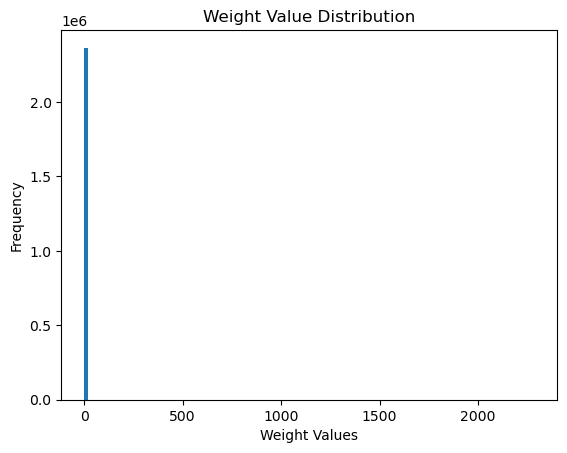

In [82]:
get_weights_range(model_autoenc)
plot_weight_distribution(model_autoenc_att)

Uncomment to load the weights

In [70]:
# model_autoenc.save_weights('./models/300_20/model_autoenc_weights', overwrite=True, save_format=None, options=None)
# model_autoenc_att.save_weights('./models/300_20/model_autoenc_att_weights', overwrite=True, save_format=None, options=None)
# model_autoenc_att2.save_weights('./models/300_20/model_autoenc_att2_weights', overwrite=True, save_format=None, options=None)
# model_autoenc_inc.save_weights('./models/300_20/model_autoenc_inc_weights', overwrite=True, save_format=None, options=None)
# model_autoenc_att_res.save_weights('./models/300_20/model_autoenc_att_res_weights', overwrite=True, save_format=None, options=None)
# model_3lstm_conv.save_weights('./models/300_20/model_3lstm_conv_weights', overwrite=True, save_format=None, options=None)

In [42]:
# Load Weights for 300/20
# model_3lstm_conv.load_weights('./models/300_20/model_3lstm_conv_weights', skip_mismatch=False, by_name=False, options=None)
# model_autoenc.load_weights('./models/300_20/model_autoenc_weights', skip_mismatch=False, by_name=False, options=None)
# model_autoenc_att.load_weights('./models/300_20/model_autoenc_att_weights', skip_mismatch=False, by_name=False, options=None)
# model_autoenc_att2.load_weights('./models/300_20/model_autoenc_att2_weights', skip_mismatch=False, by_name=False, options=None)
# model_autoenc_att_res.load_weights('./models/300_20/model_autoenc_att_res_weights', skip_mismatch=False, by_name=False, options=None)

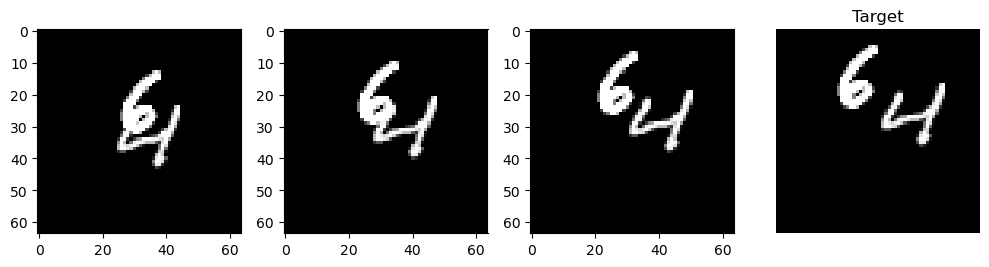

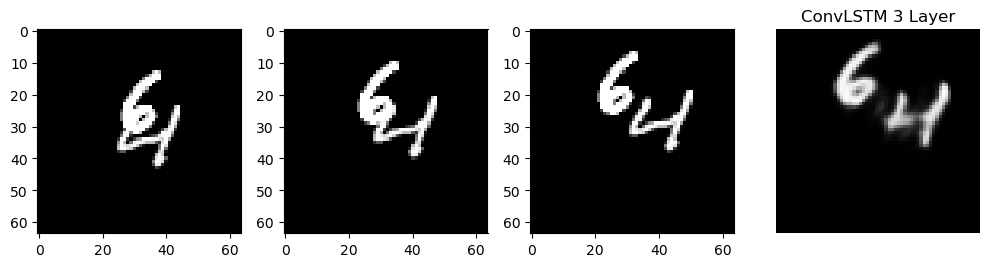

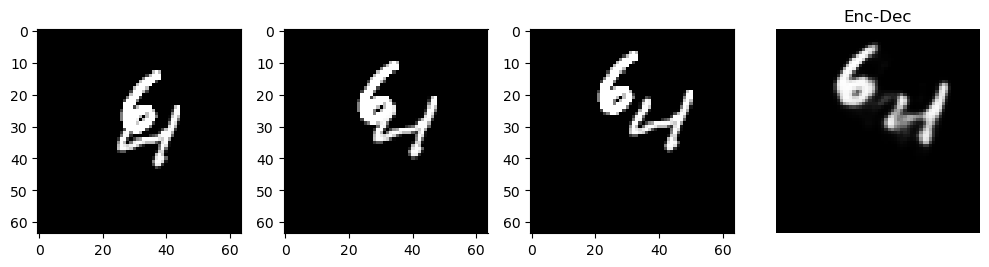

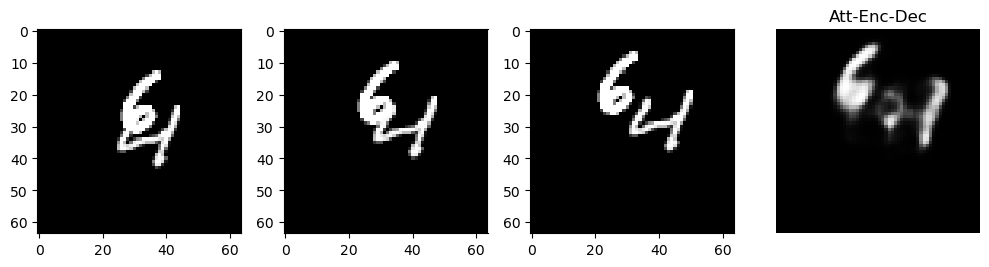

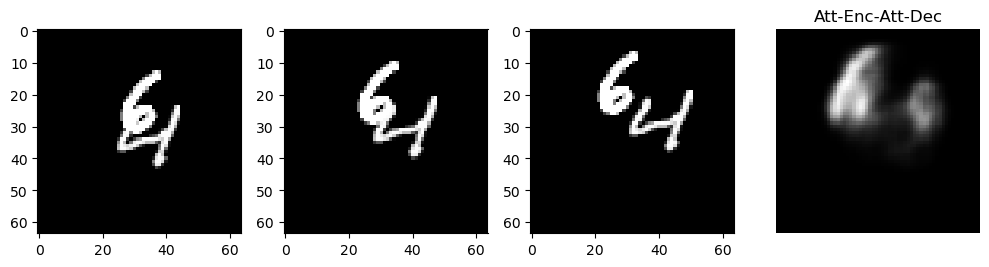

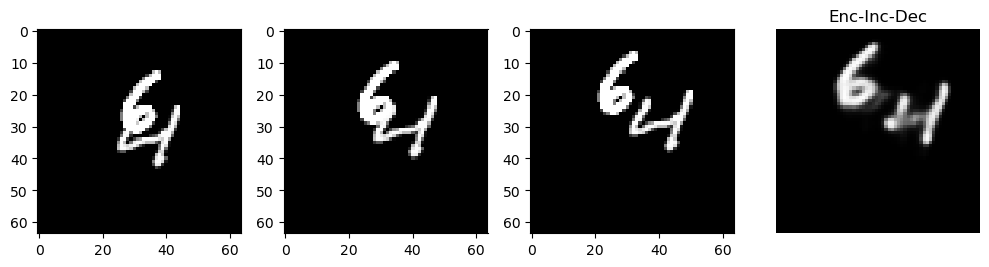

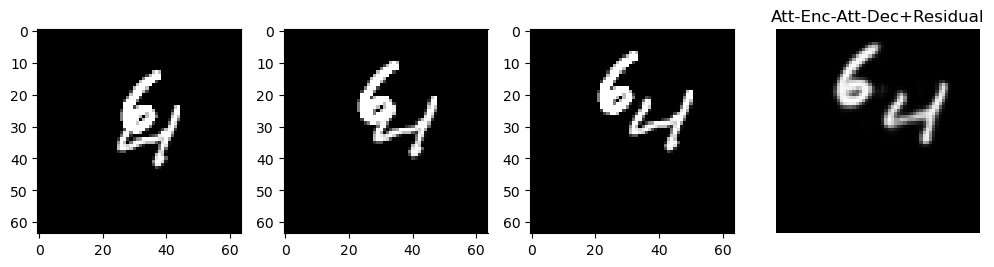

In [43]:
models = {
  'lstm3': {
    'model': model_3lstm_conv,
    'name': 'ConvLSTM 3 Layer'
  },
  'autoenc': {
    'model': model_autoenc,
    'name': 'Enc-Dec',
  },
  'autoenc_att': {
    'model': model_autoenc_att,
    'name': 'Att-Enc-Dec'
  },
  'autoenc_att2': {
    'model': model_autoenc_att2,
    'name': 'Att-Enc-Att-Dec'
  },
  'autoenc_inc': {
    'model': model_autoenc_inc,
    'name': 'Enc-Inc-Dec'
  },
  'autoenc_att_res': {
    'model': model_autoenc_att_res,
    'name': 'Att-Enc-Att-Dec+Residual'
  },
}
# visual_test(model_autoenc, sample_x, sample_y)
compare_models_visual(models, test_gen)
# print(f'Avg mse: {compute_mse(model_autoenc, test_gen)}')

In [71]:
compare_models_mse(models, test_gen)

Evaluating ConvLSTM 3 Layer
  10/1000 [..............................] - ETA: 12s - loss: 0.0730 - mse: 0.0158

2023-07-08 16:16:13.103417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 11s 11ms/step - loss: 0.0728 - mse: 0.0159
Evaluating Enc-Dec
  22/1000 [..............................] - ETA: 7s - loss: 0.0658 - mse: 0.0138

2023-07-08 16:16:23.965971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 8s 8ms/step - loss: 0.0569 - mse: 0.0112
Evaluating Att-Enc-Dec
  22/1000 [..............................] - ETA: 7s - loss: 0.0663 - mse: 0.0145

2023-07-08 16:16:31.780242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 8s 8ms/step - loss: 0.0687 - mse: 0.0150
Evaluating Att-Enc-Att-Dec
  20/1000 [..............................] - ETA: 8s - loss: 0.1086 - mse: 0.0263

2023-07-08 16:16:39.814607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 8s 8ms/step - loss: 0.1004 - mse: 0.0243
Evaluating Enc-Inc-Dec
  13/1000 [..............................] - ETA: 9s - loss: 0.0620 - mse: 0.0128 

2023-07-08 16:16:48.050946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 9s 9ms/step - loss: 0.0564 - mse: 0.0111
Evaluating Att-Enc-Att-Dec+Residual
  13/1000 [..............................] - ETA: 12s - loss: 0.0485 - mse: 0.0087

2023-07-08 16:16:57.438805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 13s 13ms/step - loss: 0.0519 - mse: 0.0096


Only the models that where below the baseline MSE of the 3-layer LSTM (0.016) were trained more extensively

## Training 500 steps / 30 epochs

In [24]:
LR_SCHEDULE = [
    (5, 0.001),
]

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_mse", patience=3, min_lr=0.001, factor=0.2)
reduce_lr = CustomLearningRateScheduler(LR_SCHEDULE)

In [89]:
train_model(model_3lstm_conv, train_gen, val_gen, epochs=30, steps_per_epoch=500, val_steps=60, callbacks=[early_stopping, reduce_lr])
model_3lstm_conv.save_weights('./models/500_30/model_3lstm_conv_weights', overwrite=True, save_format=None, options=None)

Epoch 1/30


2023-07-08 17:02:19.128609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - ETA: 0s - loss: 0.1140 - mse: 0.0255

2023-07-08 17:05:17.081245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - 185s 360ms/step - loss: 0.1140 - mse: 0.0255 - val_loss: 0.1192 - val_mse: 0.0279 - lr: 0.0050
Epoch 2/30
500/500 [==============================] - 183s 365ms/step - loss: 0.0832 - mse: 0.0194 - val_loss: 0.0825 - val_mse: 0.0192 - lr: 0.0050
Epoch 3/30
500/500 [==============================] - 184s 368ms/step - loss: 0.0801 - mse: 0.0183 - val_loss: 0.0804 - val_mse: 0.0183 - lr: 0.0050
Epoch 4/30
500/500 [==============================] - 185s 370ms/step - loss: 0.0785 - mse: 0.0178 - val_loss: 0.0806 - val_mse: 0.0182 - lr: 0.0050
Epoch 5/30
500/500 [==============================] - 156s 313ms/step - loss: 0.0775 - mse: 0.0175 - val_loss: 0.0768 - val_mse: 0.0172 - lr: 0.0050
Epoch 6/30
500/500 [==============================] - 181s 361ms/step - loss: 0.0750 - mse: 0.0166 - val_loss: 0.0743 - val_mse: 0.0164 - lr: 1.0000e-03
Epoch 7/30
500/500 [==============================] - 187s 373ms/step - loss: 0.0738 - mse: 0.0163 - val_loss: 0.

In [92]:
train_model(model_autoenc_att, train_gen, val_gen, epochs=30, steps_per_epoch=500, val_steps=60, callbacks=[early_stopping, reduce_lr])
model_autoenc_att.save_weights('./models/500_30/model_autoenc_att_weights', overwrite=True, save_format=None, options=None)

Epoch 1/30


2023-07-08 19:15:10.230457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - ETA: 0s - loss: 0.1765 - mse: 0.0385

2023-07-08 19:16:59.405190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - 114s 216ms/step - loss: 0.1765 - mse: 0.0385 - val_loss: 0.1914 - val_mse: 0.0438 - lr: 0.0050
Epoch 2/30
500/500 [==============================] - 109s 217ms/step - loss: 0.1488 - mse: 0.0353 - val_loss: 0.1749 - val_mse: 0.0373 - lr: 0.0050
Epoch 3/30
500/500 [==============================] - 110s 219ms/step - loss: 0.1416 - mse: 0.0346 - val_loss: 0.1406 - val_mse: 0.0341 - lr: 0.0050
Epoch 4/30
500/500 [==============================] - 110s 219ms/step - loss: 0.1412 - mse: 0.0345 - val_loss: 0.1649 - val_mse: 0.0379 - lr: 0.0050
Epoch 5/30
500/500 [==============================] - 110s 221ms/step - loss: 0.1405 - mse: 0.0343 - val_loss: 0.1381 - val_mse: 0.0336 - lr: 0.0050
Epoch 6/30
500/500 [==============================] - 111s 222ms/step - loss: 0.1383 - mse: 0.0340 - val_loss: 0.1378 - val_mse: 0.0336 - lr: 1.0000e-03
Epoch 7/30
500/500 [==============================] - 111s 221ms/step - loss: 0.1381 - mse: 0.0339 - val_loss: 0.

In [25]:
LR_SCHEDULE2 = [
    (5, 0.001),
    (10, 0.0005),
]

reduce_lr2 = CustomLearningRateScheduler(LR_SCHEDULE2)

In [96]:
train_model(model_autoenc, train_gen, val_gen, epochs=30, steps_per_epoch=500, val_steps=60, callbacks=[early_stopping, reduce_lr2])
model_autoenc.save_weights('./models/500_30/model_autoenc_weights', overwrite=True, save_format=None, options=None)

Epoch 1/30


2023-07-08 21:48:27.393274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - ETA: 0s - loss: 0.0942 - mse: 0.0210

2023-07-08 21:50:12.643894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - 110s 209ms/step - loss: 0.0942 - mse: 0.0210 - val_loss: 0.0813 - val_mse: 0.0190 - lr: 0.0050
Epoch 2/30
500/500 [==============================] - 105s 210ms/step - loss: 0.0707 - mse: 0.0158 - val_loss: 0.0690 - val_mse: 0.0152 - lr: 0.0050
Epoch 3/30
500/500 [==============================] - 106s 212ms/step - loss: 0.0678 - mse: 0.0148 - val_loss: 0.0690 - val_mse: 0.0154 - lr: 0.0050
Epoch 4/30
500/500 [==============================] - 107s 213ms/step - loss: 0.0652 - mse: 0.0140 - val_loss: 0.0643 - val_mse: 0.0136 - lr: 0.0050
Epoch 5/30
500/500 [==============================] - 107s 213ms/step - loss: 0.0640 - mse: 0.0135 - val_loss: 0.0636 - val_mse: 0.0133 - lr: 0.0050
Epoch 6/30
500/500 [==============================] - 107s 214ms/step - loss: 0.0608 - mse: 0.0124 - val_loss: 0.0606 - val_mse: 0.0123 - lr: 1.0000e-03
Epoch 7/30
500/500 [==============================] - 107s 215ms/step - loss: 0.0600 - mse: 0.0122 - val_loss: 0.

In [97]:
train_model(model_autoenc_att_res, train_gen, val_gen, epochs=30, steps_per_epoch=500, val_steps=60, callbacks=[early_stopping])
model_autoenc_att_res.save_weights('./models/500_30/model_autoenc_att_res_weights', overwrite=True, save_format=None, options=None)

Epoch 1/30


2023-07-08 22:32:00.568758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - ETA: 0s - loss: 0.0942 - mse: 0.0225

2023-07-08 22:35:21.278728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - 210s 403ms/step - loss: 0.0942 - mse: 0.0225 - val_loss: 0.1918 - val_mse: 0.0375
Epoch 2/30
500/500 [==============================] - 204s 408ms/step - loss: 0.0683 - mse: 0.0149 - val_loss: 0.0652 - val_mse: 0.0138
Epoch 3/30
500/500 [==============================] - 205s 409ms/step - loss: 0.0632 - mse: 0.0132 - val_loss: 0.0616 - val_mse: 0.0127
Epoch 4/30
500/500 [==============================] - 193s 386ms/step - loss: 0.0604 - mse: 0.0123 - val_loss: 0.0585 - val_mse: 0.0117
Epoch 5/30
500/500 [==============================] - 169s 338ms/step - loss: 0.0578 - mse: 0.0115 - val_loss: 0.0565 - val_mse: 0.0111
Epoch 6/30
500/500 [==============================] - 169s 337ms/step - loss: 0.0565 - mse: 0.0110 - val_loss: 0.0561 - val_mse: 0.0109
Epoch 7/30
500/500 [==============================] - 168s 337ms/step - loss: 0.0549 - mse: 0.0105 - val_loss: 0.0554 - val_mse: 0.0107
Epoch 8/30
500/500 [==============================] - 168s 

In [36]:
train_model(model_autoenc_att_res, train_gen, val_gen, epochs=20, steps_per_epoch=500, val_steps=60, callbacks=[early_stopping])

Epoch 1/20


2023-07-09 17:55:48.828657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 11/500 [..............................] - ETA: 2:30 - loss: 0.0492 - mse: 0.0087

500/500 [==============================] - ETA: 0s - loss: 0.0481 - mse: 0.0083

2023-07-09 17:58:22.885566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - 161s 322ms/step - loss: 0.0481 - mse: 0.0083 - val_loss: 0.0482 - val_mse: 0.0084
Epoch 2/20
500/500 [==============================] - 161s 321ms/step - loss: 0.0478 - mse: 0.0083 - val_loss: 0.0479 - val_mse: 0.0083
Epoch 3/20
500/500 [==============================] - 161s 321ms/step - loss: 0.0480 - mse: 0.0083 - val_loss: 0.0487 - val_mse: 0.0085
Epoch 4/20
500/500 [==============================] - 161s 322ms/step - loss: 0.0476 - mse: 0.0082 - val_loss: 0.0488 - val_mse: 0.0085
Epoch 5/20
500/500 [==============================] - 161s 322ms/step - loss: 0.0476 - mse: 0.0082 - val_loss: 0.0478 - val_mse: 0.0083
Epoch 6/20
500/500 [==============================] - 161s 322ms/step - loss: 0.0476 - mse: 0.0082 - val_loss: 0.0480 - val_mse: 0.0084
Epoch 7/20
500/500 [==============================] - 161s 322ms/step - loss: 0.0474 - mse: 0.0081 - val_loss: 0.0477 - val_mse: 0.0082
Epoch 8/20
500/500 [==============================] - 161s 

In [39]:
model_autoenc_att_res.save_weights('./models/500_30/model_autoenc_att_res_weights', overwrite=True, save_format=None, options=None)

In [26]:
train_model(model_autoenc_inc, train_gen, val_gen, epochs=30, steps_per_epoch=500, val_steps=60, callbacks=[early_stopping, reduce_lr])
# model_autoenc_inc.save_weights('./models/500_30/model_autoenc_inc_weights', overwrite=True, save_format=None, options=None)

Epoch 1/30


2023-07-09 12:31:35.016964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-09 12:31:40.280965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-09 12:31:44.149463: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7ff51c62a040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-09 12:31:44.149489: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2023-07-09 12:31:44.153228: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-09 1

500/500 [==============================] - ETA: 0s - loss: 0.1208 - mse: 0.0290

2023-07-09 12:33:44.490154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - 135s 245ms/step - loss: 0.1208 - mse: 0.0290 - val_loss: 0.1282 - val_mse: 0.0313 - lr: 0.0050
Epoch 2/30
500/500 [==============================] - 124s 248ms/step - loss: 0.1023 - mse: 0.0250 - val_loss: 0.0991 - val_mse: 0.0240 - lr: 0.0050
Epoch 3/30
500/500 [==============================] - 125s 250ms/step - loss: 0.0986 - mse: 0.0239 - val_loss: 0.1157 - val_mse: 0.0294 - lr: 0.0050
Epoch 4/30
500/500 [==============================] - 125s 250ms/step - loss: 0.0875 - mse: 0.0209 - val_loss: 0.0754 - val_mse: 0.0176 - lr: 0.0050
Epoch 5/30
500/500 [==============================] - 126s 251ms/step - loss: 0.0714 - mse: 0.0161 - val_loss: 0.0695 - val_mse: 0.0154 - lr: 0.0050
Epoch 6/30
500/500 [==============================] - 123s 246ms/step - loss: 0.0663 - mse: 0.0144 - val_loss: 0.0660 - val_mse: 0.0142 - lr: 1.0000e-03
Epoch 7/30
500/500 [==============================] - 105s 210ms/step - loss: 0.0652 - mse: 0.0140 - val_loss: 0.

In [29]:
LR_SCHEDULE3 = [
    (5, 0.001),
]

reduce_lr3 = CustomLearningRateScheduler(LR_SCHEDULE3)

In [38]:
train_model(model_autoenc_inc, train_gen, val_gen, epochs=20, steps_per_epoch=500, val_steps=60, callbacks=[early_stopping, reduce_lr3])

Epoch 1/20


2023-07-09 18:31:50.058183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - ETA: 0s - loss: 0.0532 - mse: 0.0100

2023-07-09 18:33:52.635729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - 128s 256ms/step - loss: 0.0532 - mse: 0.0100 - val_loss: 0.0530 - val_mse: 0.0099 - lr: 0.0010
Epoch 2/20
500/500 [==============================] - 186s 373ms/step - loss: 0.0529 - mse: 0.0100 - val_loss: 0.0529 - val_mse: 0.0099 - lr: 0.0010
Epoch 3/20
500/500 [==============================] - 155s 309ms/step - loss: 0.0525 - mse: 0.0098 - val_loss: 0.0527 - val_mse: 0.0099 - lr: 0.0010
Epoch 4/20
500/500 [==============================] - 104s 209ms/step - loss: 0.0526 - mse: 0.0098 - val_loss: 0.0522 - val_mse: 0.0097 - lr: 0.0010
Epoch 5/20
500/500 [==============================] - 105s 210ms/step - loss: 0.0525 - mse: 0.0098 - val_loss: 0.0526 - val_mse: 0.0099 - lr: 0.0010
Epoch 6/20
500/500 [==============================] - 105s 210ms/step - loss: 0.0523 - mse: 0.0097 - val_loss: 0.0525 - val_mse: 0.0097 - lr: 1.0000e-03
Epoch 7/20
500/500 [==============================] - 105s 210ms/step - loss: 0.0521 - mse: 0.0097 - val_loss: 0.

In [40]:
model_autoenc_inc.save_weights('./models/500_30/model_autoenc_inc_weights', overwrite=True, save_format=None, options=None)

In [42]:
# Load Weights for 500/30
# model_3lstm_conv.load_weights('./models/500_30/model_3lstm_conv_weights', skip_mismatch=False, by_name=False, options=None)
model_autoenc.load_weights('./models/500_30/model_autoenc_weights', skip_mismatch=False, by_name=False, options=None)
model_autoenc_att.load_weights('./models/500_30/model_autoenc_att_weights', skip_mismatch=False, by_name=False, options=None)
# model_autoenc_att_res.load_weights('./models/500_30/model_autoenc_att_res_weights', skip_mismatch=False, by_name=False, options=None)
# model_autoenc_inc.load_weights('./models/500_30/model_autoenc_inc_weights', skip_mismatch=False, by_name=False, options=None)

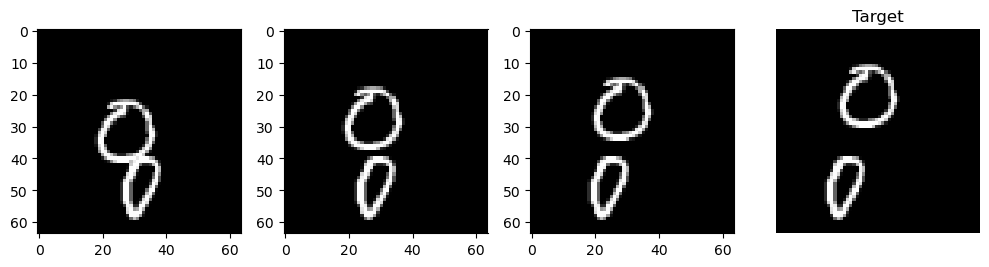

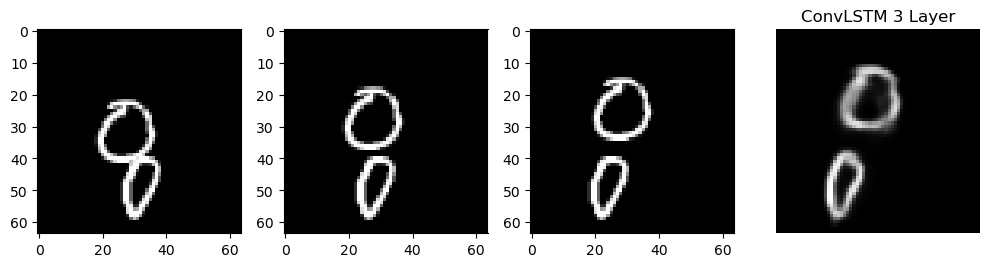

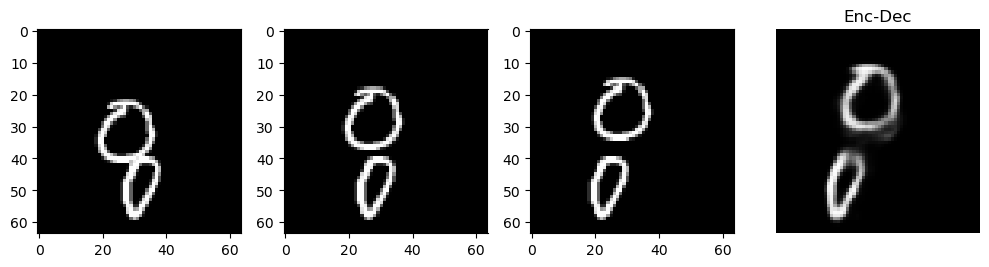

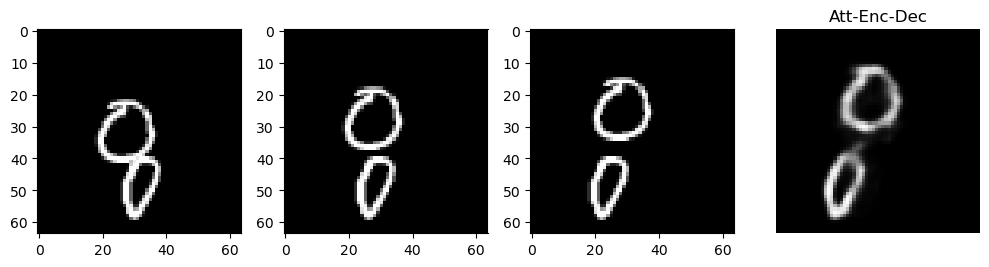

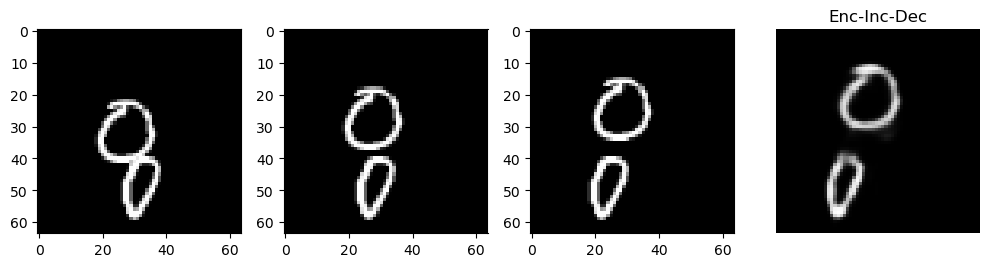

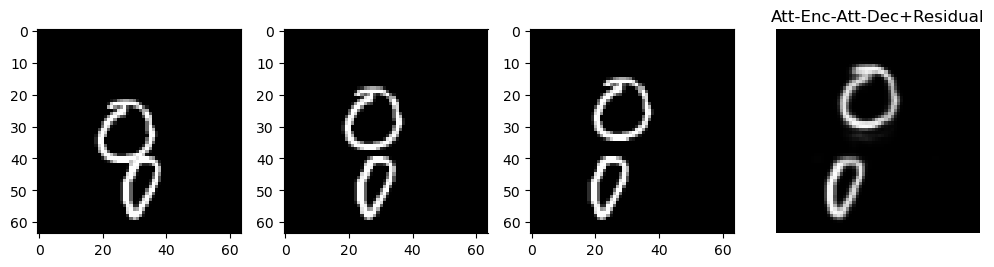

In [45]:
models2 = {
  'lstm3': {
    'model': model_3lstm_conv,
    'name': 'ConvLSTM 3 Layer'
  },
  'autoenc': {
    'model': model_autoenc,
    'name': 'Enc-Dec',
  },
  'autoenc_att': {
    'model': model_autoenc_att,
    'name': 'Att-Enc-Dec'
  },
  'autoenc_inc': {
    'model': model_autoenc_inc,
    'name': 'Enc-Inc-Dec'
  },
  'autoenc_att_res': {
    'model': model_autoenc_att_res,
    'name': 'Att-Enc-Att-Dec+Residual'
  },
}
compare_models_visual(models2, test_gen)

In [44]:
compare_models_mse(models2, test_gen)

Evaluating ConvLSTM 3 Layer
  15/1000 [..............................] - ETA: 12s - loss: 0.0777 - mse: 0.0174

2023-07-09 20:37:16.157304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 11s 11ms/step - loss: 0.0726 - mse: 0.0159
Evaluating Enc-Dec


2023-07-09 20:37:26.921635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 8s 7ms/step - loss: 0.0545 - mse: 0.0104
Evaluating Att-Enc-Dec


2023-07-09 20:37:35.007087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 9s 8ms/step - loss: 0.0650 - mse: 0.0138
Evaluating Enc-Inc-Dec
  19/1000 [..............................] - ETA: 8s - loss: 0.0430 - mse: 0.0074

2023-07-09 20:37:43.586911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 9s 9ms/step - loss: 0.0508 - mse: 0.0093
Evaluating Att-Enc-Att-Dec+Residual
  13/1000 [..............................] - ETA: 12s - loss: 0.0475 - mse: 0.0080

2023-07-09 20:37:52.639798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 13s 13ms/step - loss: 0.0475 - mse: 0.0081


The last two models, the one with the residual connection and the other with the inception module, were trained for 20 more epochs to check if they could further improve. 

References
1) Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting. https://arxiv.org/abs/1506.04214
2) Batch Normalization: Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift https://arxiv.org/pdf/1502.03167.pdf
3) BN + Dropout: https://arxiv.org/pdf/1905.05928.pdf
4) Super Convergence: https://arxiv.org/pdf/1708.07120.pdf
5) SimVP: https://arxiv.org/pdf/2211.12509v3.pdf
6) A DISCIPLINED APPROACH TO NEURAL NETWORK HYPER-PARAMETERS: https://arxiv.org/pdf/1803.09820.pdf
7) No More Pesky Learning Rate Guessing Games: https://arxiv.org/pdf/1506.01186v2.pdf
8) Inception-v4: https://arxiv.org/pdf/1602.07261v2.pdf
9) Rethinking the Inception Architecture for Computer Vision: https://arxiv.org/pdf/1512.00567.pdf